In [1]:
import pandas as pd
import os
import re
import glob
import json
import matplotlib.pyplot as plt 
from tqdm._tqdm_notebook import tqdm_notebook
import numpy as np
from scipy.sparse import hstack, vstack
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from feature_extraction import hand_features,  word_overlap_features, cosine_features
from feature_extraction import gen_or_load_feats, polarity_features, bait_features
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

%matplotlib inline

In [2]:
import ipywidgets as widgets
from ipywidgets import interact

In [3]:
import sys

my_utils_path = '/home/kim/spam-detector/src/utils'
if my_utils_path not in sys.path:
    sys.path.append(my_utils_path)

from text_preprocessing import Preprocessor
from plot_tools import plot_cm

In [4]:
fake_headline = "Сбитый над Донбассом \"Боинг\" выбрали спецслужбы"
fake_body = "Среди погибших не было граждан США и Израиля \n\nОперацию по крушению пассажирского лайнера над Донбассом Украина готовила совместно с западными спецслужбами. Только упасть самолет должен был в Ростовской области. Но исполнители немного не рассчитали, и малазийский \"Боинг\" до России не дотянул, рухнул на украинской территории. Поэтому обвинить Россию в терроризме в 2014 году не удалось, отмечает военный эксперт Алексей Леонков. \n\n\"Здесь была грамотная работа специальных служб, которые способны выстроить сложный сценарий. По нему самолет должен был упасть на территории Ростовской области. И тогда неопровержимые доказательства того, что Россия причастна к этому, были бы предъявлены всему миру. Но что-то пошло не так\", – приводит \"Царьград\" слова Леонкова. По теме Казнить нельзя, помиловать: украинцам простят сбитый под Донбассом \"Боинг\" \"Боинг\" над Донбассом сбила Украина. LIVE \n\nОн обращает внимание, что на борту сбитого лайнера были граждане многих стран, однако – ни одного американца или жителя Израиля. По мнению эксперта, тут дело не только в том, что Израиль – союзник США. Просто украинцы в 2001 г. уже сбивали пассажирский самолет. Тогда погибли 78 человек, из них 51 - гражданин Израиля. \"Она сбила самолет своим комплексом С-200 во время учений. Не закрыла небо в том месте, где проводила учения\", – напомнил Леонков. \n\nНебо над Донбассом, где в 2014 г. шла настоящая война, Киев также \"забывчиво\" не закрыл. Однако подстраховался и проследил, чтобы на сбитом лайнере не было пассажиров из стран, отношения с которыми портить никак нельзя. \n\nНакануне Минобороны РФ обнародовало информацию, согласно которой \"Боинг\" Малазийских авиалиний был сбит из \"Бука\", принадлежащего украинской армии."
fake_url = "https:\/\/www.utro.ru\/politics\/2018\/09\/18\/1374232.shtml"

print("HEADLINE: {0}\n\nARTICLE: \n{1}\n\nLINK: {2}".format(fake_headline, fake_body, fake_url))

HEADLINE: Сбитый над Донбассом "Боинг" выбрали спецслужбы

ARTICLE: 
Среди погибших не было граждан США и Израиля 

Операцию по крушению пассажирского лайнера над Донбассом Украина готовила совместно с западными спецслужбами. Только упасть самолет должен был в Ростовской области. Но исполнители немного не рассчитали, и малазийский "Боинг" до России не дотянул, рухнул на украинской территории. Поэтому обвинить Россию в терроризме в 2014 году не удалось, отмечает военный эксперт Алексей Леонков. 

"Здесь была грамотная работа специальных служб, которые способны выстроить сложный сценарий. По нему самолет должен был упасть на территории Ростовской области. И тогда неопровержимые доказательства того, что Россия причастна к этому, были бы предъявлены всему миру. Но что-то пошло не так", – приводит "Царьград" слова Леонкова. По теме Казнить нельзя, помиловать: украинцам простят сбитый под Донбассом "Боинг" "Боинг" над Донбассом сбила Украина. LIVE 

Он обращает внимание, что на борту сбитого

# More bait 

In [5]:
data = pd.read_json("../data/interim/training-gbc-normalized-02-04.json", orient='records', lines=True)

In [6]:
@interact
def show_by_source(label=data.label.unique()):
    df=data
    print("Total number of posts: {}".format(df.shape[0]))
    print("Number of posts from source {0}: {1}".format(label, df[df["label"]==label].shape[0]))
    return df[df["label"]==label].head(10)

interactive(children=(Dropdown(description='label', options=('Journalism', 'Clickbait', 'Artificial'), value='…

## Preprocessing 2.0

In [7]:
with open("../data/external/stopwords.txt", mode="r") as f:
    stopwords = [s.replace("\n", "") for s in f.readlines()]

p = Preprocessor(stopwords=stopwords)

In [8]:
bait = gen_or_load_feats(bait_features, 
                         data.title.tolist(),
                         data.text.tolist(),
                         "../data/interim/features/bait_.npy")

In [9]:
polarity = gen_or_load_feats(polarity_features,
                             data.title.tolist(),
                             data.text.tolist(),
                             "../data/interim/features/polar_.npy")

12575it [03:05, 67.92it/s]


In [10]:
overlap = gen_or_load_feats(word_overlap_features,
                            data.title.tolist(), 
                            data.text.tolist(), 
                            "../data/interim/features/overlap.fixed.npy")

hand = gen_or_load_feats(hand_features,
                         data.title.tolist(), 
                         data.text.tolist(), 
                         "../data/interim/features/hand.fixed.npy")

cosine = gen_or_load_feats(cosine_features, 
                           data.title.tolist(), 
                           data.text.tolist(), 
                           "../data/interim/features/cosine.fixed.npy")

12575it [03:05, 67.95it/s]
12575it [03:32, 59.18it/s]
0it [00:00, ?it/s]/home/kim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kim/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
12575it [00:43, 286.18it/s]


In [27]:
generated_features = np.hstack((bait, polarity, overlap, hand))   
np.save("../data/interim/matrixform/generated_features.fixed.npy", generated_features)

In [28]:
le = LabelEncoder()
y = le.fit_transform(data["label"].tolist())

### Train Stochastic Gradient Boosting Classifier on generated features

In [29]:
X_train, X_test, y_train, y_test = train_test_split(generated_features, y, test_size=0.2)

In [30]:
parameters = {'min_samples_split' : range(100, 1000, 200), 
              'min_samples_leaf' : range(30, 71, 10)}

clf = GradientBoostingClassifier(n_estimators=300, random_state=42, verbose=False)
gb_gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=1, n_jobs=8)

In [ ]:
gb_gs.fit(X_train, y_train)

In [33]:
gb_gs.best_score_

0.8830019880715706

In [34]:
gb_gs.best_params_

{'min_samples_leaf': 60, 'min_samples_split': 700}

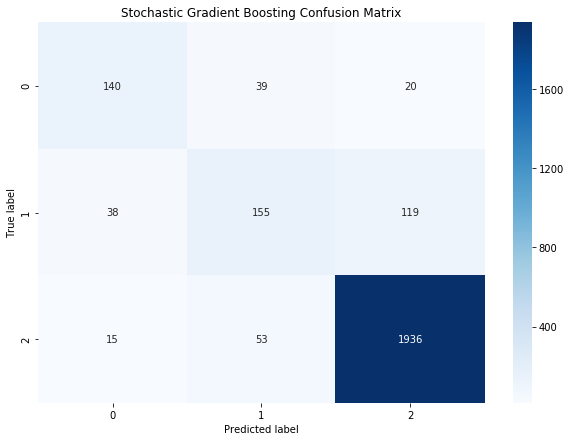

In [35]:
plot_cm(confusion_matrix(y_test, gb_gs.best_estimator_.predict(X_test)), 
        classes=gb_gs.classes_, classifier_name="Stochastic Gradient Boosting")

## With TF-IDF

In [36]:
tfidf = TfidfVectorizer(min_df=0.001, max_df=0.9, ngram_range=(1,2))
text_tfidf = tfidf.fit_transform(data.title_norm.values.flatten())
title_tfidf = tfidf.transform(data.text_norm.values.flatten())

In [37]:
len(tfidf.vocabulary_)

1631

In [38]:
X = hstack((title_tfidf, text_tfidf, generated_features))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
parameters = {#"n_estimators" : 50*np.linspace(start=2, stop=8, num=6, dtype=int),
              "subsample" : 0.1*np.linspace(start=5, stop=9, num=5, dtype=int)}

clf = GradientBoostingClassifier(n_estimators=300, random_state=42, verbose=True)
gb_tfidf_gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=1, n_jobs=10)

In [43]:
gb_tfidf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed:  4.4min finished


      Iter       Train Loss      OOB Improve   Remaining Time 
         1        6805.4270          85.0968            2.44m
         2        6178.5886          72.1892            2.27m
         3        5632.0604          59.3272            2.18m
         4        5170.0739          47.8776            2.28m
         5        4784.0592          43.6013            2.21m
         6        4426.6882          36.8440            2.16m
         7        4124.9397          31.0750            2.13m
         8        3870.2059          26.8581            2.10m
         9        3639.1639          23.5269            2.07m
        10        3432.4278          19.3639            2.06m
        20        2321.5318           7.3120            1.97m
        30        1837.3563           3.4626            1.88m
        40        1529.7079           1.7326            1.79m
        50        1372.6826           0.6159            1.71m
        60        1231.5538           0.4093            1.63m
       

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...   subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [44]:
gb_tfidf_gs.best_params_

{'subsample': 0.9}

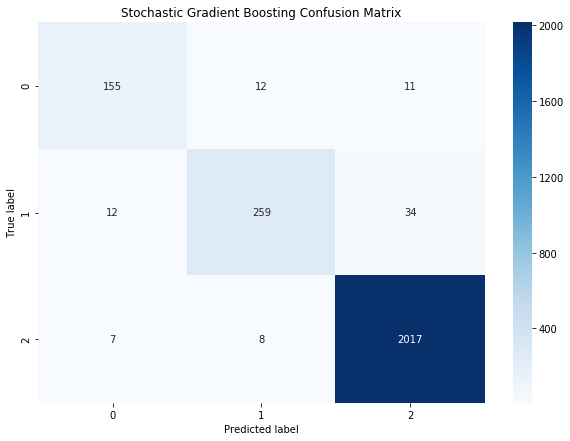

In [45]:
plot_cm(confusion_matrix(y_test, gb_tfidf_gs.best_estimator_.predict(X_test)), 
        classes=gb_gs.classes_, classifier_name="Stochastic Gradient Boosting")

Let's save our data and models and souls

In [47]:
np.save("../data/interim/matrixform/text-tfidf-and-generated-05-04.npy", X)

In [222]:
if not os.path.exists("../models/ensemble"):
    os.mkdir("../models/ensemble")

joblib.dump(gb_gs.best_estimator_, "../models/ensemble/gbc-generated-feats-no-tf-idf-05-04.pkl")
joblib.dump(gb_tfidf_gs.best_estimator_, "../models/ensemble/gbc-generated-feats-with-tf-idf-05-04.pkl")

['../models/ensemble/gbc-generated-feats-with-tf-idf-04-04.pkl']

### Test on completly new unseen data

**NB:** NaN cosine distance values will be replaced with 0.5

### 1st example

In [48]:
example_title = "Звезду первого советского фильма ужасов убило проклятье"
example_body = "В студенческие годы она напророчила Анатолию Ромашину трех жен, столько же детей (двух дочерей и сына) и смерть в 83 года. Сбылось все, кроме последнего. Актер погиб не старым – в 69 лет. А виною всему, по мнению поклонников, – его роковые роли.\n\nАктер не раз \"умирал\" и на театральной сцене, и в кино. Жизнь Анатолия Владимировича оборвала наполовину подпиленная сосна, которая упала на него, и он мгновенно скончался. После этого пошли слухи, что актер перед смертью выглядел подавленным, как будто что-то предчувствовал. И фанаты тут же заговорили о проклятье, пишет \"Телепрограмма\".\n\nОдну из самых заметных ролей Ромашин сыграл в фильме Станислава Говорухина \"Десять негритят\", вышедшем на экраны в 1987 г. и называемом первым советским триллером. В нем герой актера погиб страшной смертью – его сбросили со скалы. \n\nКак рассказывали тогда, Анатолий Владимирович отказался сниматься в этом эпизоде, и его заменил дублер, который во время съемок едва не погиб. Потом ушли из жизни партнеры Ромашина по этой картине, два Александра – Кайдановский и Абдулов, и сразу заговорили о \"нехорошей мистике\" и \"проклятии\" фильма. \n\nШирокую популярность Ромашину принесла роль царя Николая II в фильме \"Агония\". Она тоже, по мнению многих была роковой, так как рано покинули этот мир другие советские актеры, сыигравшие самодержца. После четырех инсультов в 66 лет умер Бронислав Брондуков. Запил и в 42 года скончался Юрий Демич. В 45 лет, сорвавшись со скалы через два года после гибели Ромашина, ушел из жизни Андрей Ростоцкий. А еще одного \"Романова\" – Олега Янковского - в 65 лет сжег рак.\n\nНо самым мистическим многие считают еще одно совпадение. Незадолго до несчастного случая, повлекшего смерть актера, Ромашин снялся в фильме Булата Мансурова \"Сага древних булгар\". Там сыгранного им героя – русского князя – раздавливает деревянный настил. \n\nИ, когда Анатолия Владимировича не стало, эту роль назвали пророческой. Появились даже рассказы о некоем древнем проклятии, которое сгубило полного сил и замыслов талантливого и любимого человека..."

In [49]:
print("HEADLINE: {0}\n\nARTICLE: {1}".format(example_title, example_body))

HEADLINE: Звезду первого советского фильма ужасов убило проклятье

ARTICLE: В студенческие годы она напророчила Анатолию Ромашину трех жен, столько же детей (двух дочерей и сына) и смерть в 83 года. Сбылось все, кроме последнего. Актер погиб не старым – в 69 лет. А виною всему, по мнению поклонников, – его роковые роли.

Актер не раз "умирал" и на театральной сцене, и в кино. Жизнь Анатолия Владимировича оборвала наполовину подпиленная сосна, которая упала на него, и он мгновенно скончался. После этого пошли слухи, что актер перед смертью выглядел подавленным, как будто что-то предчувствовал. И фанаты тут же заговорили о проклятье, пишет "Телепрограмма".

Одну из самых заметных ролей Ромашин сыграл в фильме Станислава Говорухина "Десять негритят", вышедшем на экраны в 1987 г. и называемом первым советским триллером. В нем герой актера погиб страшной смертью – его сбросили со скалы. 

Как рассказывали тогда, Анатолий Владимирович отказался сниматься в этом эпизоде, и его заменил дублер,

In [62]:
example_tfidf_title = tfidf.transform([" ".join(example_title)])
example_tfidf_text = tfidf.transform([" ".join(example_body)])

example_bait = gen_or_load_feats(bait_features,
                                   [" ".join(example_title)],
                                   [" ".join(p.beautify(example_body))], 
                                   "../data/interim/bait.example.npy")

example_polar = gen_or_load_feats(polarity_features,
                                   [" ".join(example_title)],
                                   [" ".join(example_body)], 
                                   "../data/interim/polarity.example.npy")

example_overlap = gen_or_load_feats(word_overlap_features,
                                    [" ".join(example_title)],
                                    [" ".join(example_body)], 
                                    "../data/interim/overlap.example.npy")

example_hand = gen_or_load_feats(hand_features,
                                 [" ".join(example_title)],
                                 [" ".join(example_body)],
                                 "../data/interim/hand.example.npy")

example_feats = hstack((example_tfidf_title, example_tfidf_text, example_bait, example_polar, example_overlap, example_hand))

1it [00:00,  1.74it/s]
1it [00:00,  5.44it/s]
1it [00:00,  5.09it/s]
1it [00:00,  4.50it/s]


#### Prediction

In [64]:
le.inverse_transform(gb_tfidf_gs.best_estimator_.predict(example_feats))

array(['Journalism'], dtype='<U10')

In [65]:
gb_tfidf_gs.best_estimator_.predict_proba(example_feats)

array([[0.00124901, 0.00415559, 0.9945954 ]])

### 2nd example

In [51]:
example_title_2 = "Адвокат уверен, что он докажет невиновность Бутиной, и ее освободят"
example_body_2 = "Суд в США оставил обвиняемую в шпионаже россиянку под стражей из-за «риска побега» \n\n \n\nРоссиянку Марию Бутину, задержанную в Вашингтоне по подозрению в шпионаже, оставили под стражей до начала судебного разбирательства по ее делу, однако адвокат Нил Дрисколл не сомневается, что ему удастся доказать невиновность своей подзащитной, и в итоге девушку освободят. \n\n«Она не является агентом российского правительства, Российской Федерации. Она невиновна в том, что ей инкриминируют», - заявил он."

In [52]:
print("HEADLINE: {0}\n\nARTICLE: {1}".format(example_title_2, example_body_2))

HEADLINE: Адвокат уверен, что он докажет невиновность Бутиной, и ее освободят

ARTICLE: Суд в США оставил обвиняемую в шпионаже россиянку под стражей из-за «риска побега» 

 

Россиянку Марию Бутину, задержанную в Вашингтоне по подозрению в шпионаже, оставили под стражей до начала судебного разбирательства по ее делу, однако адвокат Нил Дрисколл не сомневается, что ему удастся доказать невиновность своей подзащитной, и в итоге девушку освободят. 

«Она не является агентом российского правительства, Российской Федерации. Она невиновна в том, что ей инкриминируют», - заявил он.


In [67]:
example_tfidf_title_2 = tfidf.transform([" ".join(example_title_2)])
example_tfidf_text_2 = tfidf.transform([" ".join(example_body_2)])

example_bait_2 = gen_or_load_feats(bait_features,
                                   [" ".join(example_title_2)],
                                   [" ".join(p.beautify(example_body_2))], 
                                   "../data/interim/bait_2.example.npy")

example_polar_2 = gen_or_load_feats(polarity_features,
                                   [" ".join(example_title_2)],
                                   [" ".join(example_body_2)], 
                                   "../data/interim/polarity_2.example.npy")

example_overlap_2 = gen_or_load_feats(word_overlap_features,
                                    [" ".join(example_title_2)],
                                    [" ".join(example_body_2)], 
                                    "../data/interim/overlap_2.example.npy")

example_hand_2 = gen_or_load_feats(hand_features,
                                 [" ".join(example_title_2)],
                                 [" ".join(example_body_2)],
                                 "../data/interim/hand_2.example.npy")

example_feats_2 = hstack((example_tfidf_title_2, example_tfidf_text_2, example_bait_2, example_polar_2, example_overlap_2, example_hand_2))

1it [00:00, 14.58it/s]
1it [00:00, 19.97it/s]
1it [00:00, 21.17it/s]


#### Prediction

In [68]:
le.inverse_transform(gb_tfidf_gs.best_estimator_.predict(example_feats_2))

array(['Journalism'], dtype='<U10')

In [69]:
gb_tfidf_gs.best_estimator_.predict_proba(example_feats_2)

array([[0.00124901, 0.00415559, 0.9945954 ]])

### 3rd example 

In [217]:
example_title_3 = "В Сочи пройдет зимняя Олимпиада" 
example_body_3 ="Спортивные соревнования предложили вновь провести на российском курорте \n\nВ 2026 г. на Красной Поляне могут пройти олимпийские соревнования по бобслею, скелетону и санному спорту. Это произойдет в том случае, если право принять у себя зимние Олимпийские игры получит турецкий город Эрзурум.\n\n\n\"Мы много работаем, чтобы получить право на проведение Олимпиады. Мы думаем о том, чтобы провести Игры совместно с Сочи. В Сочи есть спортивные объекты, которых нет в Эрзуруме. Строить их у нас было бы слишком дорогой инвестицией, поэтому мы можем принять соревнования вместе \", - сообщил губернатор провинции Эрзурум Сейфеттин Азизоглу. Его слова приводит Inside the Games. По теме Россию обвинили в баснословных тратах на мегапроекты Олимпиада разорит хозяев \n\nВ Федерации санного спорта России с энтузиазмом восприняли эту идею.\n\n\"Отлично отношусь к этой идее и, как президент Федерации санного спорта России, ее поддерживаю. Россия – гостеприимная страна, мы всегда рады проведению мероприятий. А нам в родных стенах приятнее выступать. Но, к сожалению, этот вопрос решаю не я. Я бы каждый год международные соревнования проводила в Сочи\", – сообщила агентству \"Р-Спорт\" руководитель федерации Наталья Гарт. \n\nЭрзурум находится на северо-востоке Турции. Расстояние от него до Сочи по прямой, через горы и Черное море, составляет 431 километр. Если часть соревнований на играх в Эрзуруме будет отдана российскому курорту, то их участникам придется добираться до столицы Олимпиады и обратно на авиационном транспорте.\n\nСоревнования по указанным Азизоглу видам спорта во время сочинской Олимпиады проходили в центре \"Санки\", расположенном в Красной Поляне, в 60 км от аэропорта в Адлере. Объект был построен специально к играм. После Олимпиады на нем регулярно проводятся международные старты.\n\nТак, в сезоне 2014\/15 гг. трасса \"Санки\" приняла этап Кубка мира по бобслею и скелетону, в 2015 г. – чемпионат Европы по санному спорту, а в сезоне-2015\/16 – этап Кубка мира по санному спорту. В феврале 2017 г. в Сочи должен был пройти чемпионат мира по бобслею и скелетону, но Международная федерация бобслея и скелетона из-за допинг-скандала перенесла турнир в немецкий Кенигзее.\n\nНа проведение зимней Олимпиады в 2026 г. претендуют пять городов. Их список был обнародован в апреле этого года. Претендентами являются австрийский Грац, канадский Калгари, японский Саппоро, шведский Стокгольм, швейцарский Сьон и турецкий Эрзурум. Место проведения игр будет определено в сентябре 2019 года." "https:\/\/www.utro.ru\/sport\/2018\/09\/25\/1375031.shtml"

print("HEADLINE: {0}\n\nARTICLE: {1}".format(example_title_3, example_body_3))

HEADLINE: Кто подставил Путина: в Британии ищут виновников

ARTICLE: Жители Соединенного Королевства все чаще сомневаются, что Скрипалей отравили по приказу Кремля 

Спустя три с половиной месяца после инцидента с бывшим офицером ГРУ Сергеем Скрипалем и его дочерью Юлией, обитатели Солсбери все чаще приходят к выводу, что Россия не виновата в случившемся. 

Путин – "не глупый человек", если бы он хотел убить кого-тот, тот был бы уже мертв, "кто-то его подставил", – приводит The New York Times слова жительницы Солсбери Лизы Кэри. Издание отмечает, что сразу после отравления Скрипалей правительство Великобритании выглядело победителем в в пиар-войне: союзники поддержали Терезу Мэй, и к концу марта из стран Евросоюза, США и Канады были высланы более 100 российских дипломатов. По теме Отец прикрылся Юлией Скрипаль Разгадку тайны Скрипалей нашли у США Англия боится повторить судьбу Скрипалей на ЧМ-2018 разведчик Сергей Скрипаль 

Однако затем Британия утратила контроль над информацией, сету

In [218]:
example_tfidf_title_3 = tfidf.transform([" ".join(p.normalize_text(p.beautify(example_title_3, normalize_text=False)))])
example_tfidf_text_3 = tfidf.transform([" ".join(p.normalize_text(p.beautify(example_body_3, normalize_text=False)))])

example_overlap_3 = gen_or_load_feats(word_overlap_features,
                                    [" ".join(p.normalize(p.beautify(example_title_3, normalize_text=False)))],
                                    [" ".join(p.normalize(p.beautify(example_body_3, normalize_text=False)))], 
                                    "../data/interim/overlap.example_3.npy")

example_hand_3 = gen_or_load_feats(hand_features,
                                 [" ".join(p.normalize(p.beautify(example_title_3, normalize_text=False)))],
                                 [" ".join(p.normalize(p.beautify(example_body_3, normalize_text=False)))],
                                 "../data/interim/hand.example_3.npy")

example_cosine_3 = gen_or_load_feats(cosine_features,
                                   [" ".join(p.normalize(p.beautify(example_title_3, normalize_text=False)))],
                                   [" ".join(p.normalize(p.beautify(example_body_3, normalize_text=False)))], 
                                   "../data/interim/cosine.example_3.npy")

1it [00:00, 239.10it/s]
1it [00:00, 263.94it/s]
1it [00:00, 346.12it/s]


In [219]:
if np.isnan(example_cosine_3[0]):
    example_cosine_3[0]=0.5
    
example_feats_3 = hstack((example_tfidf_title_3, example_tfidf_text_3, 
                          example_overlap_3, example_hand_3, example_cosine_3.reshape(-1,1)))

#### Prediction

In [220]:
le.inverse_transform(gb_tfidf_gs.best_estimator_.predict(example_feats_3))

array(['Journalism'], dtype='<U10')

In [221]:
gb_tfidf_gs.best_estimator_.predict_proba(example_feats_3)

array([[0.00124192, 0.02566426, 0.97309382]])